In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import joblib, pickle
from copy import deepcopy
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, get_scorer_names
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import Ridge, Lasso
from xgboost import XGBRegressor

# 데이터 전처리

## 면적, 생산량만 추출

In [2]:
df = pd.read_csv("data/진혁_데이터프레임.csv")
# df.info()
# df.head()

In [3]:
df = df.drop(columns=df.columns[:-2])
df = df.dropna(how="any")

In [4]:
df = df.drop(df[df["생산량 (톤)"]==0].index, axis=0)
df = df.drop(df[df["면적 (ha)"]==0].index, axis=0)

## scaling 및 train, test 분리

In [5]:
feature = df["면적 (ha)"]
target = df["생산량 (톤)"]

In [19]:
mmsc_f = MinMaxScaler()
mmsc_t = MinMaxScaler()

mmsc_f.fit(feature.values.reshape(-1,1))
mmsc_t.fit(target.values.reshape(-1,1))

X = mmsc_f.transform(feature.values.reshape(-1,1))
y = mmsc_t.transform(target.values.reshape(-1,1))

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=6)

# 모델 학습

## GridSearchCV를 통한 최적의 파라미터 탐색

In [22]:
lasso = Lasso()
ridge = Ridge()
xgb = XGBRegressor()

alpha = np.logspace(-4,2,7)   # lasso, ridge 해당
max_iter = [1,3,5,10,20,50,100,150,200]   # lasso, ridge 해당
solver = ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs']   # ridge 해당, 계산에 사용할 알고리즘
eta = np.logspace(-3,2,6)   # xgboost 해당
n_estimators = [15,20,50,100,200,500]   # randomforesteregressor(사용할 tree의 개수), gradientboost, adaboost, xgboost 해당
max_depth = [2,3,5,7,10,12]  # randomforesteregressor(tree의 깊이), gradientboost, xgboost 해당
gamma = [0, 0.05, 0.1, 0.2, 0.5]    # xgboost 해당
max_leaf_nodes = [2,3,5,7]     # randomforest, xgboost 해당
min_child_weight = [1,2,3,5]   # xgboost 해당

params_lasso = {"alpha" : alpha, 
                "max_iter" : max_iter}

params_ridge = {"alpha" : alpha, 
                "max_iter" : max_iter, 
                "solver" : solver}

params_xgb = {"learning_rate" : eta,
                "n_estimators" : n_estimators, 
                "max_depth" : max_depth, 
                "gamma" : gamma,
                "min_child_weight" : min_child_weight}

In [24]:
kfold = KFold(5, shuffle=True, random_state=6)

## lasso 모델 생성

In [ ]:
grid_lasso = GridSearchCV(estimator=lasso, param_grid=params_lasso, n_jobs=-1, cv=kfold, scoring="neg_mean_squared_error")
grid_lasso.fit(X_train, y_train)

In [ ]:
print("best score :", grid_lasso.best_score_)
print("best parameter :", grid_lasso.best_params_)

In [ ]:
em = grid_lasso.best_estimator_
y_pred = em.predict(X_test)
print("r2 score :", r2_score(y_test, y_pred))

In [ ]:
y_pred_train = em.predict(X_train)
print("r2 score :", r2_score(y_train, y_pred_train))

## ridge 모델 생성

In [ ]:
grid_ridge = GridSearchCV(estimator=ridge, param_grid=params_ridge, n_jobs=-1, cv=kfold, scoring="neg_mean_squared_error")
grid_ridge.fit(X_train, y_train)

In [ ]:
print("best score :", grid_ridge.best_score_)
print("best parameter :", grid_ridge.best_params_)

In [ ]:
em = grid_ridge.best_estimator_
y_pred = em.predict(X_test)
print("r2 score :", r2_score(y_test, y_pred))

In [ ]:
y_pred_train = em.predict(X_train)
print("r2 score :", r2_score(y_train, y_pred_train))

## xgbregressor 모델 생성

In [25]:
grid_xgb = GridSearchCV(estimator=xgb, param_grid=params_xgb, n_jobs=-1, cv=kfold, scoring="neg_mean_squared_error")
grid_xgb.fit(X_train, y_train)

c:\Users\jhahn\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:953: UserWarning: One or more of the test scores are non-finite: [-0.16883614 -0.16721941 -0.15785212 ...         nan         nan
         nan]
  warnings.warn(


GridSearchCV(cv=KFold(n_splits=5, random_state=6, shuffle=True),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    inter...
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None, ...),
             n_jobs=-1,
             param_grid={'gamma': [0, 0.05, 0.1, 0.2, 0.5],
                         'learning_rate': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                         'max_depth': [2, 3, 5, 7, 10, 12],
                         'min_child_weight': [1, 2, 3, 5],
                         'n_estimators': [15, 20, 50, 100, 200, 500]},
             scoring='neg_mean_squared_error')

In [26]:
print("best score :", grid_xgb.best_score_)
print("best parameter :", grid_xgb.best_params_)

best score : -0.004351829908430106
best parameter : {'gamma': 0, 'learning_rate': 0.01, 'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 500}


In [27]:
em = grid_xgb.best_estimator_
y_pred = em.predict(X_test)
print("r2 score :", r2_score(y_test, y_pred))

r2 score : 0.8924311001570645


In [28]:
y_pred_train = em.predict(X_train)
print("r2 score :", r2_score(y_train, y_pred_train))

r2 score : 0.901782598020898


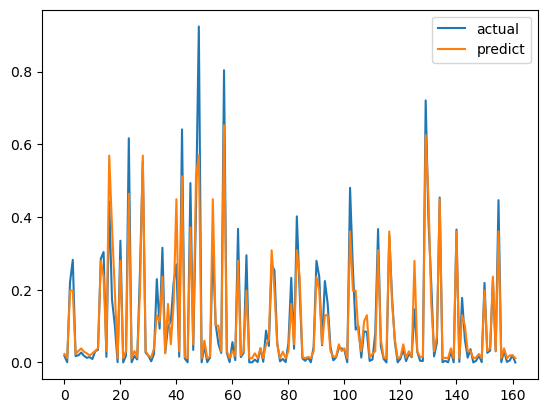

In [29]:
plt.plot(y_test.flatten(), label="actual")
plt.plot(y_pred.flatten(), label="predict")
plt.legend()
plt.show()

C:\Users\jhahn\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\jhahn\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51228 (\N{HANGUL SYLLABLE JE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\jhahn\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 44050 (\N{HANGUL SYLLABLE GABS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\jhahn\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 44284 (\N{HANGUL SYLLABLE GWA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\jhahn\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 50696 (\N{HANGUL SYLLABLE YE}) missi

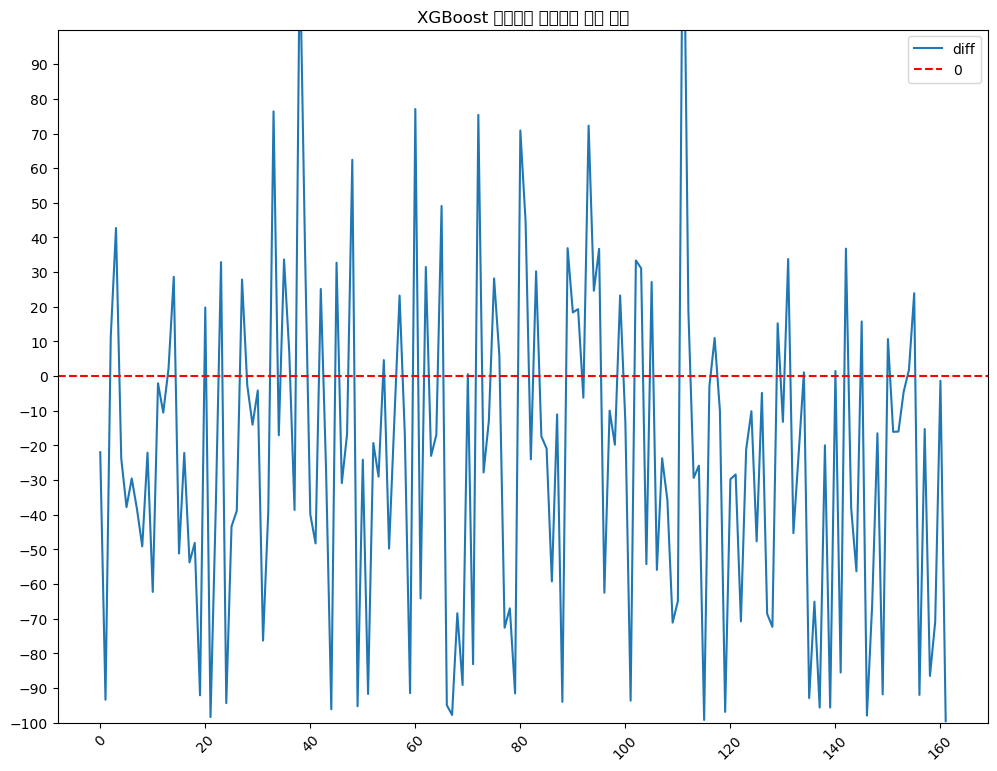

In [30]:
y_test_inv = mmsc_t.inverse_transform(y_test)
y_pred_inv = mmsc_t.inverse_transform(y_pred.reshape(-1,1))

diff = ((y_test_inv-y_pred_inv) / y_pred_inv) * 100

# 예측값과 실제값의 차이를 시각화한다,
plt.figure(figsize=(12, 9))
# y축의 범위를 -10과 10 사이로 설정한다
plt.ylim(-100, 100)
# y축의 눈금을 -10부터 10까지 2간격으로 설정한다
plt.yticks(np.arange(-100, 100, 10))
# y축 눈금에 %를 붙인다
# plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
# 글자가 겹치지 않도록 회전한다
plt.xticks(rotation=45)
plt.plot(diff)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('XGBoost 실제값과 예측값의 차이 비율')
# 범례를 표시한다
plt.legend(['diff', '0'])
plt.show()

# 모델, 스케일러 저장

## xgb 모델 저장

In [94]:
joblib.dump(em, "model/pred_xgb_output_with_area.pkl")

['model/pred_xgb_output_with_area.pkl']

## scaler 저장

In [95]:
joblib.dump(mmsc_f, "model/pred_xgb_output_with_area_sc_f.pkl")
joblib.dump(mmsc_t, "model/pred_xgb_output_with_area_sc_t.pkl")

['model/pred_xgb_output_with_area_sc_t.pkl']

In [10]:
# 모델 불러오기
test = deepcopy(X_test)

with open("model/pred_xgb_output_with_area.pkl", "rb") as m : 
    with open("model/pred_xgb_output_with_area_sc_f.pkl", "rb") as f :
        with open("model/pred_xgb_output_with_area_sc_t.pkl", "rb") as t :

            model = joblib.load(m)
            scale_f = joblib.load(f)
            scale_t = joblib.load(t)

            # test_sc = scale_f.transform(test)

            # pred = model.predict(test_sc)
            pred = model.predict(test)

            result = scale_t.inverse_transform(pred.reshape(-1,1))

            print(result[result<=0])


[]


In [8]:
with open("model/pred_xgb_output_with_area.pkl", "rb") as m : 
    with open("model/pred_xgb_output_with_area_sc_f.pkl", "rb") as f :
        with open("model/pred_xgb_output_with_area_sc_t.pkl", "rb") as t :

            model = joblib.load(m)
            scale_f = joblib.load(f)
            scale_t = joblib.load(t)

            X = scale_f.transform(feature.values.reshape(-1,1))
            y = scale_t.transform(target.values.reshape(-1,1))

            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=6)

            y_pred = model.predict(X_test)

            actual = scale_t.inverse_transform(y_test)

            result = scale_t.inverse_transform(y_pred.reshape(-1,1))

            

[21:59:49] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:553: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.



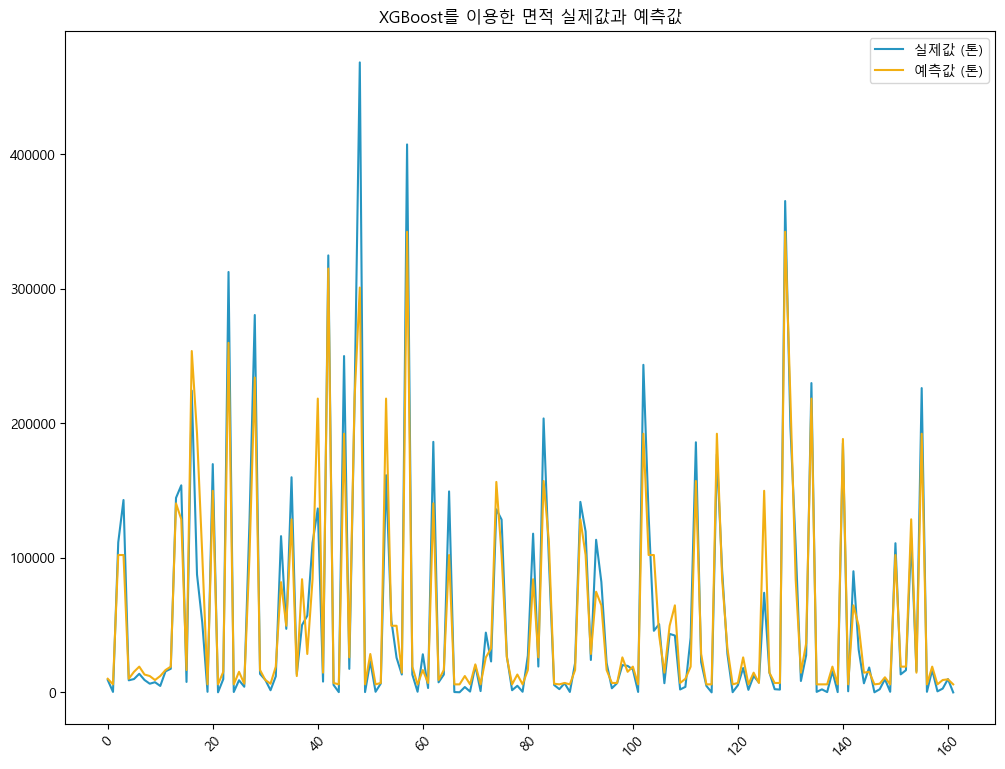

In [18]:
plt.rcParams['font.family'] = 'Malgun Gothic'

 # 예측값과 실제값의 차이를 시각화한다,
plt.figure(figsize=(12, 9))
# y축의 눈금을 -10부터 10까지 2간격으로 설정한다
# 글자가 겹치지 않도록 회전한다
plt.xticks(rotation=45)
plt.plot(actual.flatten(),color="#2695c1", label = "실제값 (톤)")
plt.plot(result.flatten(),color="#f2af13", label = "예측값 (톤)")
plt.title('XGBoost를 이용한 면적 실제값과 예측값')
# 범례를 표시한다
plt.legend()
plt.show()

In [12]:
test = deepcopy(X_test)

with open("model/pred_xgb_output_with_area.pkl", "rb") as m : 
    with open("model/pred_xgb_output_with_area_sc_f.pkl", "rb") as f :
        with open("model/pred_xgb_output_with_area_sc_t.pkl", "rb") as t :

            model = joblib.load(m)
            scale_f = joblib.load(f)
            scale_t = joblib.load(t)

            # test_sc = scale_f.transform(test)

            # pred = model.predict(test_sc)
            pred = model.predict(test)

            result = scale_t.inverse_transform(pred.reshape(-1,1))

            y_test_inv = mmsc_t.inverse_transform(y_test)

            diff = ((result-y_test_inv) / y_test_inv) * 100

            print("오차율의 최댓값 :",diff.max())

            print("실제값 :",y_test_inv[diff.argmax()])

            print("예측값 :",result[diff.argmax()])


            # # 예측값과 실제값의 차이를 시각화한다,
            # plt.figure(figsize=(12, 9))
            # # y축의 범위를 -10과 10 사이로 설정한다
            # plt.ylim(-100, 100)
            # # y축의 눈금을 -10부터 10까지 2간격으로 설정한다
            # plt.yticks(np.arange(-100, 100, 10))
            # # y축 눈금에 %를 붙인다
            # # plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
            # # 글자가 겹치지 않도록 회전한다
            # plt.xticks(rotation=45)
            # plt.plot(diff)
            # plt.axhline(y=0, color='red', linestyle='--')
            # plt.title('XGBoost 실제값과 예측값의 차이 비율')
            # # 범례를 표시한다
            # plt.legend(['diff', '0'])
            # plt.show()

오차율의 최댓값 : 600929.4921875
실제값 : [1.]
예측값 : [6010.295]
